# Домашнее задание: основы DL

## Задание 1

Вспомним 1ое зянятие - мы узнали, что в DL мы можем подбирать оптимальные параметры для любой дифференцируемой модели, считая градиенты по обучаемым параметрам.

В этом задании вам предстоит руками сделать backpropagation для совсем простой модели, чтобы понять, что в torch не происходит никакой магии




Пусть:

$x = [1, 1]^T$

$y = [1, -1]^T$

$z = [-1, 2]^T$


$l = sum(max(0, x*y)) + prod(x + z^2)$

где $sum, prod$ - поэлементные сложения и умножения соответственно



В ответ вам нужно указать $\frac{\partial l}{\partial x}$ и $\frac{\partial l}{\partial z}$, а в ноутбуке отобразить, как вы аналитически получили это значение

Для проверки, что вы правильно поняли идею backpropagation, можете подсчитать значение $\frac{\partial l}{\partial y}$, оно должно проходить assert

$$ l (x_1, x_2, y_1, y_2, z_1, z_2) = max(0, x_1 * y_1) + max(0, x_2 * y_2) + (x_1 + {z_1}^2) * (x_2 + {z_2}^2)$$

Так как $x_2 *y_2 < 0$, то тогда можно написать

$$l = x_1 * y_1 + x_1x_2 + x_1{z_2}^2 + x_2{z_1}^2 + (z_1z_2)^2$$

Тогда

$$\frac{\partial l}{\partial x_1} = y_1 + x_2 + {z_2}^2 = 1 + 1 + 4 + 6$$
$$\frac{\partial l}{\partial x_2} = x_1 + {z_1}^2 = 1 + 1 = 2$$
$$\frac{\partial l}{\partial z_1} = 2x_2z_1 + 2z_1{z_2}^2 = -2 -8 = -10$$
$$\frac{\partial l}{\partial z_2} = 2x_1z_2 + 2{z_1}^2z_2 = 4 + 4 = 8$$

Тогда ответ:

$$\frac{\partial l}{\partial x} = [6, 2]^T$$
$$\frac{\partial l}{\partial z} = [-10, 8]^T$$

In [ ]:
dl_dy = [1, 0]
assert np.all(dl_dy == [1, 0]), "Пока что неверное, попробуйте еще раз и все получится!"

In [143]:
!pip install catalyst

In [144]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

import torchvision

from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score

from catalyst import utils

# Задание 2

На занятиях мы часто говорили про линейные модели, что это просто. Давайте реализуем ее сами и попробуем обучать такую модель для задачи классификации (то есть реализуем логистическую регрессию)

На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта.

Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$.

Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$.

Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

## Задание 2.0

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры ([`nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)) модели. Иначе говоря здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).



In [168]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        res = x @ self.weights
        if self.bias:
            res += self.bias_term
        return res

### Датасет

Давайте сгенерируем датасет и посмотрим на него!

In [169]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

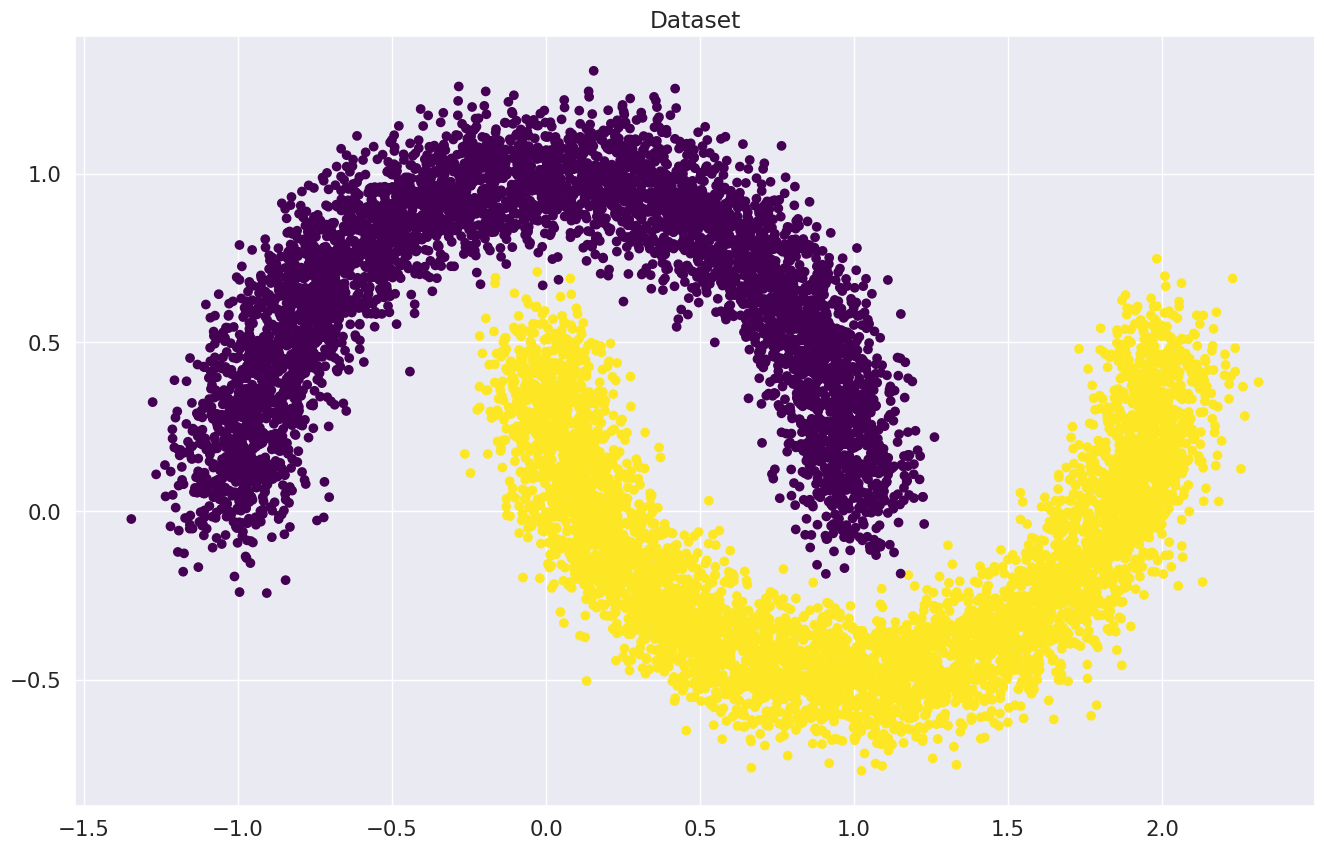

In [170]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [171]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [172]:
X_train.shape

(7500, 2)

### Загрузка данных

В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.


In [176]:
X_train_t =  torch.from_numpy(X_train.astype(np.float32))
y_train_t =  torch.from_numpy(y_train.astype(np.float32))
X_val_t =  torch.from_numpy(X_val.astype(np.float32))
y_val_t =  torch.from_numpy(y_val.astype(np.float32))

Создаем `Dataset` и `DataLoader`.

In [177]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [178]:
utils.set_global_seed(42)
linear_regression = LinearRegression(2, 1, True)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

## Задание 2.1 Сколько обучаемых параметров у получившейся модели?

**Ответ:** 3

## Задание 2.2

Теперь обучим эту модель

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

In [179]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
prev_bias = torch.zeros_like(linear_regression.bias_term)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression.forward(X_batch).squeeze()
        loss = loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach())
        optimizer.step()
        sigm = nn.Sigmoid()
        probabilities =  sigm(outp)
        preds = (probabilities>0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum()/y_batch.size(0)
        if it % 500000 == 0:
            print(f"Iteration: {it + epoch*len(train_dataset)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        current_bias = linear_regression.bias_term.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol and (prev_bias - current_bias).abs().max() < tol:
            print(f"\nIteration: {it + epoch*len(train_dataset)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
        prev_bias = current_bias
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.5625
Iteration: 7500
Batch accuracy: 0.765625
Iteration: 15000
Batch accuracy: 0.7890625
Iteration: 22500
Batch accuracy: 0.7890625
Iteration: 30000
Batch accuracy: 0.8046875
Iteration: 37500
Batch accuracy: 0.8046875
Iteration: 45000
Batch accuracy: 0.8046875
Iteration: 52500
Batch accuracy: 0.8203125
Iteration: 60000
Batch accuracy: 0.8203125
Iteration: 67500
Batch accuracy: 0.8203125
Iteration: 75000
Batch accuracy: 0.8203125
Iteration: 82500
Batch accuracy: 0.8203125
Iteration: 90000
Batch accuracy: 0.8203125
Iteration: 97500
Batch accuracy: 0.828125
Iteration: 105000
Batch accuracy: 0.828125

Iteration: 105054.Convergence. Stopping iterations.


## Задание 2.2

Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 105054


### Визуализируем результаты

881


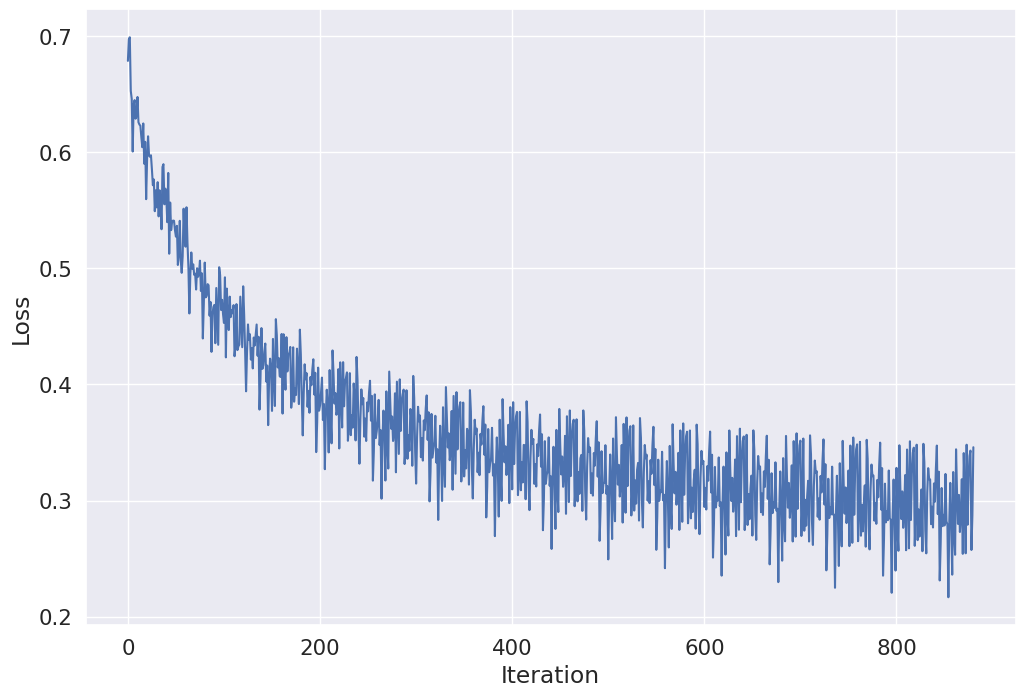

In [180]:
plt.figure(figsize=(12, 8))
print(len(losses))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [181]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

In [182]:
out = predict(val_dataloader, linear_regression)
print(accuracy_score(out, y_val_t))

0.8688


## Задание 2.3

Какое `accuracy` получается после обучения?

**Ответ:** 0.8688


# Задание 3

Теперь перейдем к датасету MNIST!

На 2ом и 3ем семинаре мы работали с этим датасетом, поэтому ваша задача взять код от туда и исследовать такой интересный вопрос: какая функция активации лучше всего подходит под эту задачу?


Вам необходимо обучить 4 раза модель ниже и сравнить качество для различных функций активаций (или их отсутствия)

In [183]:
activation = nn.ELU  # нужно перебрать: no_activation, ReLU, LeakyReLU, ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

In [184]:
mnist_train = torchvision.datasets.MNIST(
    "./mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)
mnist_val = torchvision.datasets.MNIST(
    "./mnist/", train=False, download=True, transform=torchvision.transforms.ToTensor()
)

train_dataloader = torch.utils.data.DataLoader(
    mnist_train, batch_size=4, shuffle=True,
)

val_dataloader = torch.utils.data.DataLoader(
    mnist_val, batch_size=4, shuffle=False,
)

In [185]:
def train(model, optimizer, n_epochs=5):
    acc = []
    for epoch in range(n_epochs):
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


        val_loss = []
        val_accuracy = []
        with torch.no_grad():
            for x_val, y_val in tqdm(val_dataloader):
                y_pred = model(x_val)
                loss = F.cross_entropy(y_pred, y_val)
                val_loss.append(loss.numpy())
                val_accuracy.extend(
                    (torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist()
                )
        print(
            f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}"
        )
        acc.append(np.mean(val_accuracy))
    return acc

In [186]:
all_acc = []
activation_functions = [nn.ReLU, nn.LeakyReLU, nn.ELU]

for it in range(len(activation_functions)):

    activation = activation_functions[it]
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10)
    )
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

    acc = []

    print(activation_functions[it])

    all_acc.append(train(model, optimizer, 10))

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    #activation(),
    nn.Linear(128, 128),
    #activation(),
    nn.Linear(128, 10)
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
print("no activation")
all_acc.append(train(model, optimizer, 10))

<class 'torch.nn.modules.activation.ReLU'>


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 0, loss: 0.14462263882160187, accuracy: 0.9556


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 1, loss: 0.10532750189304352, accuracy: 0.969


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 2, loss: 0.10190389305353165, accuracy: 0.9691


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 3, loss: 0.11588440090417862, accuracy: 0.9678


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 4, loss: 0.09501086920499802, accuracy: 0.9739


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 5, loss: 0.10780204087495804, accuracy: 0.9695


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 6, loss: 0.11158914864063263, accuracy: 0.9735


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 7, loss: 0.08404801040887833, accuracy: 0.9779


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 8, loss: 0.0964079275727272, accuracy: 0.9783


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 9, loss: 0.09850306063890457, accuracy: 0.9785
<class 'torch.nn.modules.activation.LeakyReLU'>


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 0, loss: 0.13815166056156158, accuracy: 0.9563


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 1, loss: 0.10270191729068756, accuracy: 0.9685


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 2, loss: 0.0777289867401123, accuracy: 0.9784


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 3, loss: 0.08130751550197601, accuracy: 0.9756


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 4, loss: 0.09522931277751923, accuracy: 0.9716


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 5, loss: 0.09417510032653809, accuracy: 0.9732


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 6, loss: 0.08435576409101486, accuracy: 0.9771


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 7, loss: 0.08961665630340576, accuracy: 0.9781


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 8, loss: 0.10013575851917267, accuracy: 0.977


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 9, loss: 0.10266325622797012, accuracy: 0.9747
<class 'torch.nn.modules.activation.ELU'>


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 0, loss: 0.13580727577209473, accuracy: 0.9568


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 1, loss: 0.1068558320403099, accuracy: 0.9648


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 2, loss: 0.12664642930030823, accuracy: 0.9648


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 3, loss: 0.11520339548587799, accuracy: 0.9669


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 4, loss: 0.09178826212882996, accuracy: 0.9767


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 5, loss: 0.1144760474562645, accuracy: 0.9703


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 6, loss: 0.1068323478102684, accuracy: 0.9729


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 7, loss: 0.13129374384880066, accuracy: 0.9705


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 8, loss: 0.16017359495162964, accuracy: 0.9656


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 9, loss: 0.1312566101551056, accuracy: 0.9733
no activation


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 0, loss: 0.39029207825660706, accuracy: 0.8896


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 1, loss: 0.5370612144470215, accuracy: 0.8572


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 2, loss: 0.45295581221580505, accuracy: 0.8772


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 3, loss: 0.48784390091896057, accuracy: 0.8725


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 4, loss: 0.4569230377674103, accuracy: 0.8684


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 5, loss: 0.4573810398578644, accuracy: 0.8768


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 6, loss: 0.49208709597587585, accuracy: 0.8641


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 7, loss: 0.36963900923728943, accuracy: 0.9015


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 8, loss: 0.3848614990711212, accuracy: 0.8954


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 9, loss: 0.4407445192337036, accuracy: 0.8867


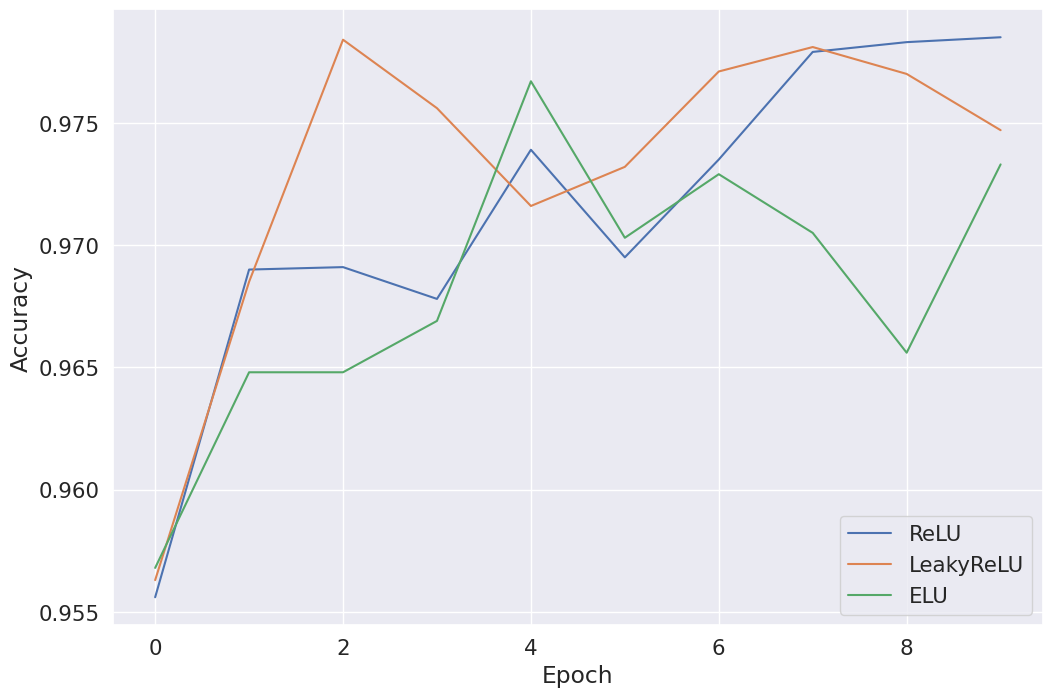

In [187]:
plt.figure(figsize=(12, 8))

plt.plot(range(10), all_acc[0], label='ReLU')
plt.plot(range(10), all_acc[1], label='LeakyReLU')
plt.plot(range(10), all_acc[2], label='ELU')
#plt.plot(range(10), all_acc[3], label='no activation')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

Необходимо построить график: valid accuracy от номера эпохи (максимум 10 эпох) для разных функций активации и выбрать лучшую из них

**Вопрос 3** Какая из активаций показала наивысший `accuracy`?

**Ответ:** необходимо указать в форме

# Задание 4

Теперь обучим архитектуру, которая использует операции nn.Conv2d. На семинарах мы наблюдали, что можем сильно увеличить качество решения.

Давайте посмотрим на архитектуру, предложенную еще в 1998 году - [LeNet](https://en.wikipedia.org/wiki/LeNet)!

In [188]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(400, 120)  # YOUR CODE HERE
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        m = nn.Flatten()
        x = m(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [189]:
model = LeNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": val_dataloader}

In [190]:
acc = []
max_epochs = 5
for epoch in range(max_epochs):
    for x_train, y_train in tqdm(train_dataloader):
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    val_loss = []
    val_accuracy = []
    with torch.no_grad():
        for x_val, y_val in tqdm(val_dataloader):
            y_pred = model(x_val)
            loss = F.cross_entropy(y_pred, y_val)
            val_loss.append(loss.numpy())
            val_accuracy.extend(
                (torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist()
            )
    print(
        f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}"
    )
    acc.append(np.mean(val_accuracy))

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 0, loss: 0.05776718258857727, accuracy: 0.982


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 1, loss: 0.06801009178161621, accuracy: 0.9778


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 2, loss: 0.048549458384513855, accuracy: 0.9839


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 3, loss: 0.05302410200238228, accuracy: 0.9845


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 4, loss: 0.04199732840061188, accuracy: 0.9879


Необходимо обучить модель и сравнить дают ли сверточные слои прирост к качеству? Для этого ответить на вопрос

## Задание 4
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.98

